#Secondary structure prediction

## Set up

In [ ]:
import os

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

!pip install -q biopython transformers datasets huggingface_hub accelerate
!pip install lightgbm

import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

  Running command git clone --filter=blob:none --quiet https://github.com/instadeepai/nucleotide-transformer /tmp/pip-req-build-m83nz6vp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00


##Import model

In [ ]:
#@title Select a model
#@markdown ---
model_name = '500M_human_ref'#@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species', '50M_multi_species_v2', '100M_multi_species_v2', '250M_multi_species_v2', '500M_multi_species_v2']
#@markdown ---

In [ ]:
embeddings_layer = 20  # layer of embeddings extraction (0:24)
seq_max_length = 200  # Max length of the protein sequence

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    embeddings_layers_to_save=(embeddings_layer,),
    max_positions= seq_max_length + 50
)
forward_fn = hk.transform(forward_fn)

tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

##Import dataset

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset_dict = load_dataset("proteinea/secondary_structure_prediction")
dataset = dataset_dict["train"].to_pandas()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def filter_dataset(dataset):
    # making subsequences of length >=100 of sequences with "X" or "O"
    filtered_rows = []

    for index, row in dataset.iterrows():
        input_string = row["input"]
        dssp3_string = row["dssp3"]
        dssp8_string = row["dssp8"]

        x_positions = [pos for pos, char in enumerate(input_string) if char == 'X']
        o_positions = [pos for pos, char in enumerate(input_string) if char == 'O']

        if not (x_positions or o_positions):
            # Keep the entire row if it doesn't contain 'X' or 'O'
            filtered_rows.append(row)
        else:
            occurrences = sorted(x_positions + o_positions)

            start_idx = 0  # First non "X" or "O"
            for i in occurrences:
                if i - start_idx >= 100:
                    new_row = {
                        "input": input_string[start_idx:i],
                        "dssp3": dssp3_string[start_idx:i],
                        "dssp8": dssp8_string[start_idx:i]
                    }
                    filtered_rows.append(new_row)
                start_idx = i + 1

            # Check for the remaining substring at the end of the input string
            if len(input_string) - start_idx >= 100:
                new_row = {
                    "input": input_string[start_idx:],
                    "dssp3": dssp3_string[start_idx:],
                    "dssp8": dssp8_string[start_idx:]
                }
                filtered_rows.append(new_row)

    # removing odd length protein sequences because of unstable embedding rappresentations
    filtered_rows = [row for row in filtered_rows if len(row["input"]) % 2 == 0]

    df = pd.concat([pd.DataFrame([row]) for row in filtered_rows], ignore_index=True)
    return df

In [ ]:
df = filter_dataset(dataset)

In [ ]:
df = df[:3000]  # Adjust to available memory

X_proteins = df["input"]
y_seq = df["dssp3"]  # Can be changed to "dssp8"

## Making amino acid sequences into dna sequences

In [ ]:
import random

def protein_to_rna(protein_sequence):
    amino_acid_to_codons = {
        "A": ["GCU", "GCC", "GCA", "GCG"],
        "R": ["CGU", "CGC", "CGA", "CGG", "AGA", "AGG"],
        "N": ["AAU", "AAC"],
        "D": ["GAU", "GAC"],
        "B": ["AAU", "AAC", "GAU", "GAC"],
        "C": ["UGU", "UGC"],
        "Q": ["CAA", "CAG"],
        "E": ["GAA", "GAG"],
        "Z": ["CAA", "CAG", "GAA", "GAG"],
        "G": ["GGU", "GGC", "GGA", "GGG"],
        "H": ["CAU", "CAC"],
        "I": ["AUU", "AUC", "AUA"],
        "L": ["CUU", "CUC", "CUA", "CUG", "UUA", "UUG"],
        "K": ["AAA", "AAG"],
        "M": ["AUG"],
        "F": ["UUU", "UUC"],
        "P": ["CCU", "CCC", "CCA", "CCG"],
        "S": ["UCU", "UCC", "UCA", "UCG", "AGU", "AGC"],
        "T": ["ACU", "ACC", "ACA", "ACG"],
        "W": ["UGG"],
        "Y": ["UAU", "UAC"],
        "V": ["GUU", "GUC", "GUA", "GUG"],
        "U": ["UGA"],
    }

    # Converts protein sequence to RNA sequence
    rna_sequence = ''
    for amino_acid in protein_sequence:
        codons = amino_acid_to_codons.get(amino_acid)
        rna_sequence += codons[random.randint(0, len(codons)-1)]  # Chose codon

    return rna_sequence

In [ ]:
X_rna = [protein_to_rna(protein) for protein in X_proteins]

In [ ]:
def rna_to_dna(rna_sequence):
    rna_to_dna_base_pairs = {'A': 'T', 'U': 'A', 'C': 'G', 'G': 'C'}

    # Convert RNA sequence to complementary DNA sequence
    dna_sequence = ''.join(rna_to_dna_base_pairs.get(base) for base in rna_sequence)

    return dna_sequence

In [ ]:
X_dna = [rna_to_dna(rna_sequence) for rna_sequence in X_rna]

#Tokenizing and retrieving embeddings

In [ ]:
batch_size = 8 # Adjust to available memory

def get_6mers_embeddings(sequences: list, batch_size: int):
    embeddings = []  # Stores 6mers embeddings

    # Split sequences into batches
    batched_sequences = [sequences[i:i + batch_size] for i in range(0, len(sequences), batch_size)]

    random_key = jax.random.PRNGKey(0)
    extraction_layer = "embeddings_" + str(embeddings_layer)
    cls_token_position = 0 # Position of the CLS token for every sequence

    for batch in batched_sequences:
        # Tokenize the batch
        tokens_ids = [b[1] for b in tokenizer.batch_tokenize(batch)]
        tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

        # Infer
        outs = forward_fn.apply(parameters, random_key, tokens)

        # Get embeddings
        batch_embeddings = outs[extraction_layer]

        # Mask for padding tokens
        padding_mask = (tokens != tokenizer.pad_token_id) & (jnp.arange(tokens.shape[1]) != cls_token_position)

        # Element-wise multiplication to set embeddings corresponding to padding tokens to zero
        masked_embeddings = batch_embeddings * padding_mask[:, :, None]

        # Removing embeddings relative to CLS and padding tokens
        sum_embeddings = jnp.sum(masked_embeddings, axis=-1)
        non_zero_mask = sum_embeddings != 0.0
        non_zero_embeddings = masked_embeddings[non_zero_mask]

        embeddings.append(non_zero_embeddings)


    return jnp.concatenate(embeddings, axis=0)

In [ ]:
X = get_6mers_embeddings(X_dna, batch_size)

In [ ]:
conc_y = ''.join(y_seq) # Concatenated sequences of target dna
y = [conc_y[i] + conc_y[i+1] for i in range(0, len(conc_y), 2)]  # Cartesian product of classes

In [ ]:
X2 = []
y2 = []
for i in range(0, len(X), 100):
    X2.append(X[i+10:i+90])
    y2.append(y[i+10:i+90])

X = jnp.concatenate(X2, axis=0)
%reset X2
y = [item for sublist in y2 for item in sublist]

## Storing embeddings - labels

In [ ]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/data"

with open('/content/drive/My Drive/data/new_X.pkl', 'wb') as f: # Storing embeddings
  pickle.dump(X, f)

with open('/content/drive/My Drive/data/new_y.pkl', 'wb') as f: # Storing labels
  pickle.dump(y, f)

# Downstream task, using left and right classifiers

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
# Loading data from drive
with open('/content/drive/My Drive/data/new_X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/content/drive/My Drive/data/new_y.pkl', 'rb') as f:
    y = pickle.load(f)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

params = {
    'objective': 'multiclass',  # 'multiclass' for multi-class classification
    'metric': 'multi_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.610245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 160800, number of used features: 1280
[LightGBM] [Info] Start training from score -0.900190
[LightGBM] [Info] Start training from score -1.512602
[LightGBM] [Info] Start training from score -0.985717
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Accuracy: 0.50


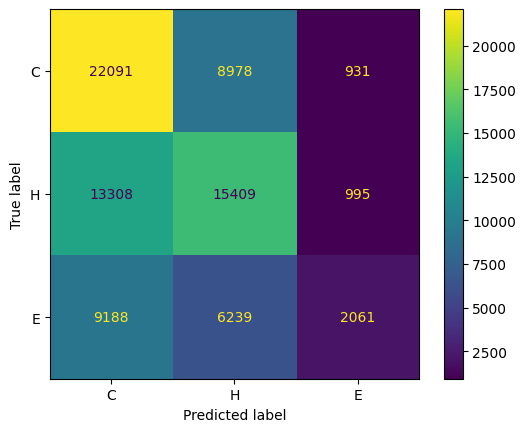

In [ ]:
# Left classifier
l_y_train = [item[0] for item in y_train]
l_y_test = [item[0] for item in y_test]

l_clf = lgb.LGBMClassifier(**params)
l_clf.fit(X_train, l_y_train)

l_y_pred = l_clf.predict(X_test)
accuracy = accuracy_score(l_y_test, l_y_pred)
print(f"Accuracy: {accuracy:.2f}")

l_cm = confusion_matrix(l_y_test, l_y_pred, labels= ["C", "H", "E"])
l_disp = ConfusionMatrixDisplay(confusion_matrix=l_cm, display_labels=["C", "H", "E"])
l_disp.plot()
plt.show()

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.708360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 160800, number of used features: 1280
[LightGBM] [Info] Start training from score -0.900970
[LightGBM] [Info] Start training from score -1.513280
[LightGBM] [Info] Start training from score -0.984468
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Accuracy: 0.50


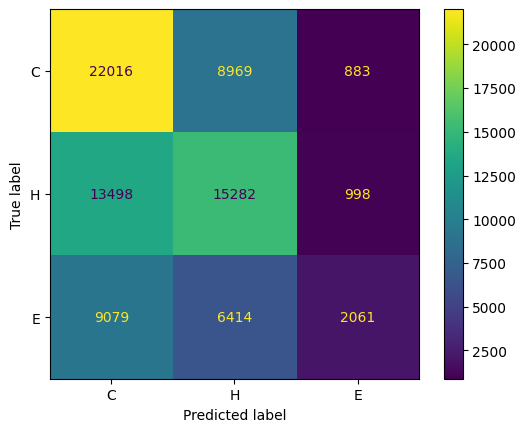

In [ ]:
# right classifier
r_y_train = [item[1] for item in y_train]
r_y_test = [item[1] for item in y_test]

r_clf = lgb.LGBMClassifier(**params)
r_clf.fit(X_train, r_y_train)

r_y_pred = r_clf.predict(X_test)
accuracy = accuracy_score(r_y_test, r_y_pred)
print(f"Accuracy: {accuracy:.2f}")

r_cm = confusion_matrix(r_y_test, r_y_pred, labels= ["C", "H", "E"])
r_disp = ConfusionMatrixDisplay(confusion_matrix=r_cm, display_labels=["C", "H", "E"])
r_disp.plot()
plt.show()

## Confusion matrix on training data

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Accuracy: 0.55


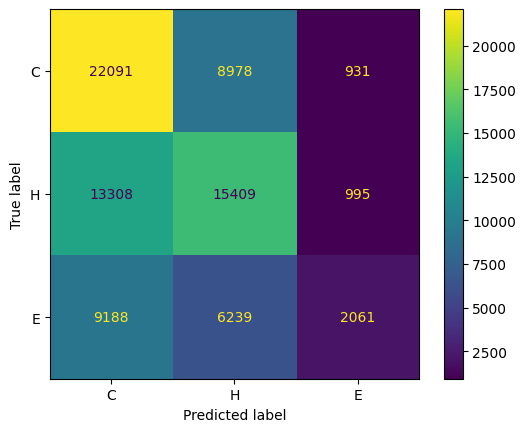

In [ ]:
l_train_pred = l_clf.predict(X_train)
accuracy = accuracy_score(l_y_train, l_train_pred)
print(f"Accuracy: {accuracy:.2f}")

l_train_cm = confusion_matrix(l_y_test, l_y_pred, labels= ["C", "H", "E"])
l_train_disp = ConfusionMatrixDisplay(confusion_matrix=l_train_cm, display_labels=["C", "H", "E"])
l_train_disp.plot()
plt.show()